In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from loguru import logger

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.sparse as sparse
import torch.optim as optim

import pandas as pd
import plotly.express as px

sys.path.insert(0, '..')

from src.viz import blueq_colors

# Implement

In [3]:
from src.train_utils import mse_loss, train, MetricLogCallback
from src.model import WideAndDeep

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = 'cpu'
logger.info(f"Using {device} device")

2024-09-09 20:39:26.077 | INFO     | __main__:<module>:9 - Using cuda device


# Test implementation

In [5]:
# Mock data
user_ids = [0, 0, 1, 2, 2]
item_ids = [0, 1, 2, 3, 1]
ratings = [1, 4, 5, 3, 2]
n_users = len(set(user_ids))
n_items = len(set(item_ids))

val_user_ids = [0, 1, 2]
val_item_ids = [2, 1, 2]
val_ratings = [2, 4, 5]

print("Mock User IDs:", user_ids)
print("Mock Item IDs:", item_ids)
print("Ratings:", ratings)

embedding_dim = 8
hidden_units = 8

model = WideAndDeep(n_users, n_items, embedding_dim, hidden_units, device)

# Example forward pass
users = torch.tensor([0, 1, 2])
items = torch.tensor([0, 1, 2])
predictions = model.predict(users, items)
print(predictions)

Mock User IDs: [0, 0, 1, 2, 2]
Mock Item IDs: [0, 1, 2, 3, 1]
Ratings: [1, 4, 5, 3, 2]
tensor([-3.0995, -2.7147,  2.1349], device='cuda:0', grad_fn=<AddBackward0>)


In [6]:
import random
import numpy as np
from torch.utils.data import DataLoader
from src.dataset_loader import UserItemRatingDataset

batch_size = 4

rating_dataset = UserItemRatingDataset(user_ids, item_ids, ratings)
dataloader = DataLoader(rating_dataset, batch_size=batch_size, shuffle=True)

val_rating_dataset = UserItemRatingDataset(val_user_ids, val_item_ids, val_ratings)
val_dataloader = DataLoader(val_rating_dataset, batch_size=batch_size, shuffle=True)

# Instantiate LightGCN model
model = WideAndDeep(n_users, n_items, embedding_dim, hidden_units, device)

# Training loop
n_epochs = 50

train(model, dataloader, val_dataloader, epochs=n_epochs, patience=2, print_steps=1, lr=0.001, device=device, progress_bar_type='tqdm_notebook')

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s]

2024-09-09 20:39:26.980 | INFO     | src.train_utils:train:122 - Step 1, Global Loss: 21.5344
2024-09-09 20:39:26.981 | INFO     | src.train_utils:train:125 - Step 1, Learning Rate: 0.001000
2024-09-09 20:39:26.981 | INFO     | src.train_utils:train:128 - Step 1, Gradient Norms: {'grad_norm_user_bias.weight': 0.39801257848739624, 'grad_norm_item_bias.weight': 0.4170202612876892, 'grad_norm_user_embedding.weight': 0.03639910742640495, 'grad_norm_item_embedding.weight': 0.04403328895568848, 'grad_norm_fc1.weight': 0.3312337100505829, 'grad_norm_fc1.bias': 0.09168926626443863, 'grad_norm_fc2.weight': 0.19402308762073517, 'grad_norm_fc2.bias': 0.28082147240638733, 'grad_norm_fc3.weight': 0.07862041890621185, 'grad_norm_fc3.bias': 0.650850772857666, 'total_grad_norm': 0.9999999927155507}
2024-09-09 20:39:26.985 | INFO     | src.train_utils:train:122 - Step 2, Global Loss: 17.2114
2024-09-09 20:39:26.986 | INFO     | src.train_utils:train:125 - Step 2, Learning Rate: 0.001000
2024-09-09 20:3

Training Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s]

2024-09-09 20:39:26.994 | INFO     | src.train_utils:train:122 - Step 3, Global Loss: 23.3793
2024-09-09 20:39:26.994 | INFO     | src.train_utils:train:125 - Step 3, Learning Rate: 0.001000
2024-09-09 20:39:26.995 | INFO     | src.train_utils:train:128 - Step 3, Gradient Norms: {'grad_norm_user_bias.weight': 0.39400458335876465, 'grad_norm_item_bias.weight': 0.4026597738265991, 'grad_norm_user_embedding.weight': 0.024775788187980652, 'grad_norm_item_embedding.weight': 0.04349987208843231, 'grad_norm_fc1.weight': 0.2956594228744507, 'grad_norm_fc1.bias': 0.09692598134279251, 'grad_norm_fc2.weight': 0.17412982881069183, 'grad_norm_fc2.bias': 0.27407124638557434, 'grad_norm_fc3.weight': 0.1771700233221054, 'grad_norm_fc3.bias': 0.6681951284408569, 'total_grad_norm': 0.9999999580622969}
2024-09-09 20:39:26.997 | INFO     | src.train_utils:train:122 - Step 4, Global Loss: 13.4162
2024-09-09 20:39:26.997 | INFO     | src.train_utils:train:125 - Step 4, Learning Rate: 0.001000
2024-09-09 20:

Training Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s]

2024-09-09 20:39:27.005 | INFO     | src.train_utils:train:122 - Step 5, Global Loss: 21.4254
2024-09-09 20:39:27.005 | INFO     | src.train_utils:train:125 - Step 5, Learning Rate: 0.001000
2024-09-09 20:39:27.005 | INFO     | src.train_utils:train:128 - Step 5, Gradient Norms: {'grad_norm_user_bias.weight': 0.396413654088974, 'grad_norm_item_bias.weight': 0.4133457839488983, 'grad_norm_user_embedding.weight': 0.03462960943579674, 'grad_norm_item_embedding.weight': 0.043702658265829086, 'grad_norm_fc1.weight': 0.3430618643760681, 'grad_norm_fc1.bias': 0.08972398191690445, 'grad_norm_fc2.weight': 0.2232450693845749, 'grad_norm_fc2.bias': 0.25916266441345215, 'grad_norm_fc3.weight': 0.07922696322202682, 'grad_norm_fc3.bias': 0.6479736566543579, 'total_grad_norm': 0.9999999546078459}
2024-09-09 20:39:27.008 | INFO     | src.train_utils:train:122 - Step 6, Global Loss: 17.0058
2024-09-09 20:39:27.008 | INFO     | src.train_utils:train:125 - Step 6, Learning Rate: 0.001000
2024-09-09 20:39

# Prep data

In [7]:
train_df = pd.read_parquet("../data/train.parquet")
val_df = pd.read_parquet("../data/val.parquet")

In [8]:
from src.id_mapper import IDMapper

In [9]:
user_ids = train_df['user_id'].values
item_ids = train_df['parent_asin'].values
unique_user_ids = list(set(user_ids))
unique_item_ids = list(set(item_ids))
n_users = len(unique_user_ids)
n_items = len(unique_item_ids)

logger.info(f"{len(unique_user_ids)=:,.0f}, {len(unique_item_ids)=:,.0f}")

2024-09-09 20:39:27.087 | INFO     | __main__:<module>:8 - len(unique_user_ids)=5,223, len(unique_item_ids)=2,653


In [10]:
idm = IDMapper()
idm.fit(unique_user_ids, unique_item_ids)

In [11]:
user_indices = [idm.get_user_index(user_id) for user_id in user_ids]
item_indices = [idm.get_item_index(item_id) for item_id in item_ids]
ratings = train_df['rating'].values.tolist()

In [12]:
val_user_indices = [idm.get_user_index(user_id) for user_id in val_df['user_id']]
val_item_indices = [idm.get_item_index(item_id) for item_id in val_df['parent_asin']]
val_ratings = val_df['rating'].values.tolist()

# Train

In [13]:
batch_size = 128

rating_dataset = UserItemRatingDataset(user_indices, item_indices, ratings)
dataloader = DataLoader(rating_dataset, batch_size=batch_size, shuffle=True)

val_rating_dataset = UserItemRatingDataset(val_user_indices, val_item_indices, val_ratings)
val_dataloader = DataLoader(val_rating_dataset, batch_size=batch_size, shuffle=True)

In [14]:
embedding_dim = 128
hidden_units = 128

model = WideAndDeep(n_users, n_items, embedding_dim, hidden_units, device)

#### Predict before train

In [15]:
user_id = 'AEHW2B54HDLZ3APBEWXHYLZ6SSYQ'
val_df.loc[lambda df: df['user_id'].eq(user_id)]

,user_id,parent_asin,rating,timestamp
34367,AEHW2B54HDLZ3APBEWXHYLZ6SSYQ,B07MYVF61Y,4.0,1654225907045


In [16]:
item_id = 'B07MYVF61Y'
user_indice = idm.get_user_index(user_id)
item_indice = idm.get_item_index(item_id)

model.predict([user_indice], [item_indice])

tensor(-0.4749, device='cuda:0', grad_fn=<AddBackward0>)

#### Training loop

In [17]:
n_epochs = 50

metric_log_cb = MetricLogCallback()

train(
    model,
    dataloader,
    val_dataloader,
    epochs=n_epochs,
    patience=2,
    print_steps=100,
    lr=0.03,
    device=device,
    progress_bar_type='tqdm_notebook',
    callbacks=[metric_log_cb.process_payload]
)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:39:36.922 | INFO     | src.train_utils:train:122 - Step 100, Global Loss: 7.4947
2024-09-09 20:39:36.922 | INFO     | src.train_utils:train:125 - Step 100, Learning Rate: 0.030000
2024-09-09 20:39:36.923 | INFO     | src.train_utils:train:128 - Step 100, Gradient Norms: {'grad_norm_user_bias.weight': 0.027099991217255592, 'grad_norm_item_bias.weight': 0.027036117389798164, 'grad_norm_user_embedding.weight': 0.02118118293583393, 'grad_norm_item_embedding.weight': 0.02124330960214138, 'grad_norm_fc1.weight': 0.045846518129110336, 'grad_norm_fc1.bias': 0.011965569108724594, 'grad_norm_fc2.weight': 0.08332450687885284, 'grad_norm_fc2.bias': 0.008008829317986965, 'grad_norm_fc3.weight': 0.9911265969276428, 'grad_norm_fc3.bias': 0.0777846947312355, 'total_grad_norm': 0.9999999323075041}
2024-09-09 20:39:37.070 | INFO     | src.train_utils:train:140 - Epoch 1, Loss: 5.9412
2024-09-09 20:39:37.106 | INFO     | src.train_utils:train:155 - Epoch 1, Validation Loss: 2.8323


Training Epoch 2:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:39:37.299 | INFO     | src.train_utils:train:122 - Step 200, Global Loss: 1.7321
2024-09-09 20:39:37.299 | INFO     | src.train_utils:train:125 - Step 200, Learning Rate: 0.030000
2024-09-09 20:39:37.300 | INFO     | src.train_utils:train:128 - Step 200, Gradient Norms: {'grad_norm_user_bias.weight': 0.008349291048943996, 'grad_norm_item_bias.weight': 0.008978172205388546, 'grad_norm_user_embedding.weight': 0.00960500631481409, 'grad_norm_item_embedding.weight': 0.007819886319339275, 'grad_norm_fc1.weight': 0.01594294048845768, 'grad_norm_fc1.bias': 0.009749325923621655, 'grad_norm_fc2.weight': 0.08496008813381195, 'grad_norm_fc2.bias': 0.007861063815653324, 'grad_norm_fc3.weight': 0.9950550198554993, 'grad_norm_fc3.bias': 0.04395922273397446, 'total_grad_norm': 0.9999999352079629}
2024-09-09 20:39:37.556 | INFO     | src.train_utils:train:140 - Epoch 2, Loss: 1.6556
2024-09-09 20:39:37.592 | INFO     | src.train_utils:train:155 - Epoch 2, Validation Loss: 2.3364


Training Epoch 3:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:39:37.651 | INFO     | src.train_utils:train:122 - Step 300, Global Loss: 0.9973
2024-09-09 20:39:37.652 | INFO     | src.train_utils:train:125 - Step 300, Learning Rate: 0.030000
2024-09-09 20:39:37.653 | INFO     | src.train_utils:train:128 - Step 300, Gradient Norms: {'grad_norm_user_bias.weight': 0.060126084834337234, 'grad_norm_item_bias.weight': 0.05812102556228638, 'grad_norm_user_embedding.weight': 0.025917844846844673, 'grad_norm_item_embedding.weight': 0.02605995535850525, 'grad_norm_fc1.weight': 0.03339201956987381, 'grad_norm_fc1.bias': 0.008614946156740189, 'grad_norm_fc2.weight': 0.11593911796808243, 'grad_norm_fc2.bias': 0.010195920243859291, 'grad_norm_fc3.weight': 0.9872727990150452, 'grad_norm_fc3.bias': 0.04703936725854874, 'total_grad_norm': 0.9999997087623932}
2024-09-09 20:39:37.875 | INFO     | src.train_utils:train:122 - Step 400, Global Loss: 1.1238
2024-09-09 20:39:37.876 | INFO     | src.train_utils:train:125 - Step 400, Learning Rate: 0.030000


Training Epoch 4:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:39:38.126 | INFO     | src.train_utils:train:122 - Step 500, Global Loss: 0.8506
2024-09-09 20:39:38.127 | INFO     | src.train_utils:train:125 - Step 500, Learning Rate: 0.030000
2024-09-09 20:39:38.127 | INFO     | src.train_utils:train:128 - Step 500, Gradient Norms: {'grad_norm_user_bias.weight': 0.17049604654312134, 'grad_norm_item_bias.weight': 0.16608309745788574, 'grad_norm_user_embedding.weight': 0.014411590993404388, 'grad_norm_item_embedding.weight': 0.016385283321142197, 'grad_norm_fc1.weight': 0.015662765130400658, 'grad_norm_fc1.bias': 0.00339046330191195, 'grad_norm_fc2.weight': 0.11800750344991684, 'grad_norm_fc2.bias': 0.004930066876113415, 'grad_norm_fc3.weight': 0.3920583724975586, 'grad_norm_fc3.bias': 0.09321221709251404, 'total_grad_norm': 0.48346028519007456}
2024-09-09 20:39:38.280 | INFO     | src.train_utils:train:140 - Epoch 4, Loss: 0.8815
2024-09-09 20:39:38.304 | INFO     | src.train_utils:train:155 - Epoch 4, Validation Loss: 2.1536


Training Epoch 5:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:39:38.378 | INFO     | src.train_utils:train:122 - Step 600, Global Loss: 0.6823
2024-09-09 20:39:38.378 | INFO     | src.train_utils:train:125 - Step 600, Learning Rate: 0.030000
2024-09-09 20:39:38.379 | INFO     | src.train_utils:train:128 - Step 600, Gradient Norms: {'grad_norm_user_bias.weight': 0.14782637357711792, 'grad_norm_item_bias.weight': 0.14477208256721497, 'grad_norm_user_embedding.weight': 0.0, 'grad_norm_item_embedding.weight': 0.0, 'grad_norm_fc1.weight': 0.0, 'grad_norm_fc1.bias': 0.0, 'grad_norm_fc2.weight': 0.0, 'grad_norm_fc2.bias': 0.0, 'grad_norm_fc3.weight': 0.0, 'grad_norm_fc3.bias': 0.06386686116456985, 'total_grad_norm': 0.21654230203547892}
2024-09-09 20:39:38.594 | INFO     | src.train_utils:train:122 - Step 700, Global Loss: 0.7665
2024-09-09 20:39:38.594 | INFO     | src.train_utils:train:125 - Step 700, Learning Rate: 0.030000
2024-09-09 20:39:38.595 | INFO     | src.train_utils:train:128 - Step 700, Gradient Norms: {'grad_norm_user_bias.w

# Visualize training

In [18]:
step_metrics = [p for p in metric_log_cb.payloads if 'step' in p]
epoch_metrics = [p for p in metric_log_cb.payloads if 'epoch' in p]
step_metrics_df = pd.DataFrame(step_metrics)
step_metrics_df

,step,dataset,global_loss,learning_rate,grad_norm_user_bias.weight,grad_norm_item_bias.weight,grad_norm_user_embedding.weight,grad_norm_item_embedding.weight,grad_norm_fc1.weight,grad_norm_fc1.bias,grad_norm_fc2.weight,grad_norm_fc2.bias,grad_norm_fc3.weight,grad_norm_fc3.bias,total_grad_norm
0,100,train,7.494658,0.03,0.027100,0.027036,0.021181,0.021243,0.045847,0.011966,0.083325,0.008009,0.991127,0.077785,1.000000
1,200,train,1.732143,0.03,0.008349,0.008978,0.009605,0.007820,0.015943,0.009749,0.084960,0.007861,0.995055,0.043959,1.000000
2,300,train,0.997312,0.03,0.060126,0.058121,0.025918,0.026060,0.033392,0.008615,0.115939,0.010196,0.987273,0.047039,1.000000
3,400,train,1.123791,0.03,0.160713,0.163356,0.000582,0.000615,0.001078,0.000219,0.003776,0.000200,0.025710,0.252613,0.342060
4,500,train,0.850598,0.03,0.170496,0.166083,0.014412,0.016385,0.015663,0.003390,0.118008,0.004930,0.392058,0.093212,0.483460
5,600,train,0.682305,0.03,0.147826,0.144772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063867,0.216542
6,700,train,0.766525,0.03,0.187723,0.195912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.174936,0.322837


In [19]:
epoch_metrics_df = pd.DataFrame(epoch_metrics)
epoch_metrics_df = epoch_metrics_df.pipe(lambda df: pd.melt(df, id_vars=["epoch"], var_name="loss_type", value_name="value"))
epoch_metrics_df

,epoch,loss_type,value
0,1,train_loss,5.941183
1,2,train_loss,1.655608
2,3,train_loss,1.138412
3,4,train_loss,0.881499
4,1,val_loss,2.832258
5,2,val_loss,2.336360
6,3,val_loss,2.131216
7,4,val_loss,2.153612


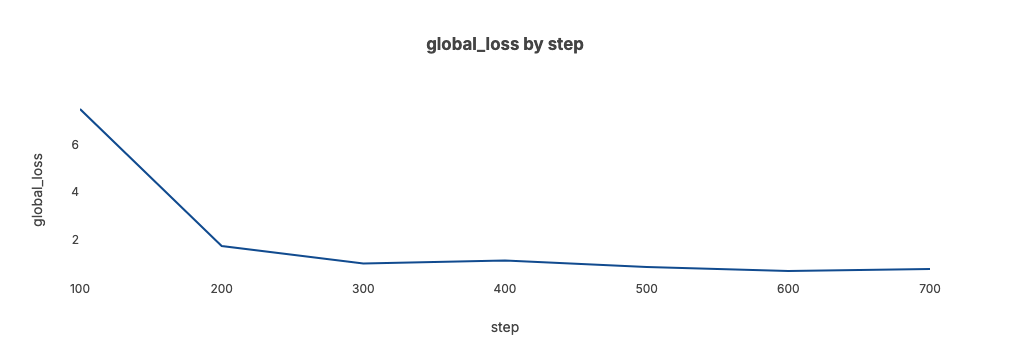

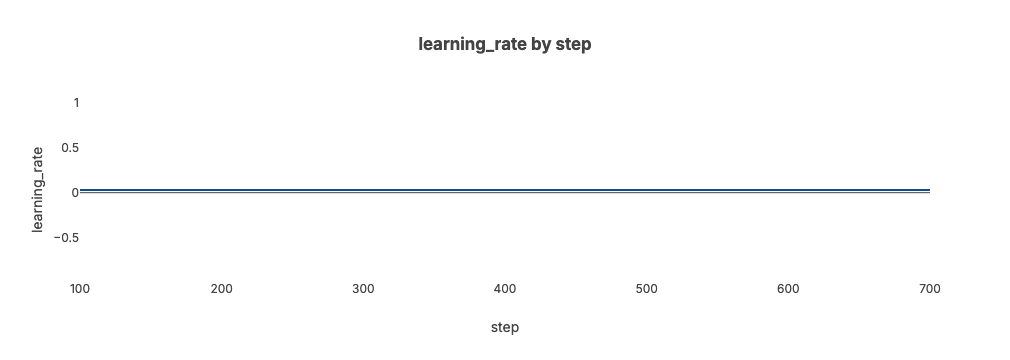

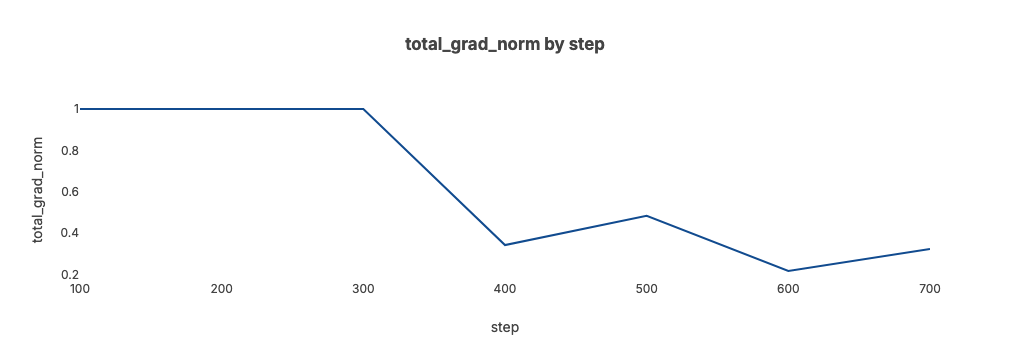

In [41]:
from src.eval import plot_metric, plot_train_vs_val_loss

plot_metric(step_metrics_df, col='global_loss')
plot_metric(step_metrics_df, col='learning_rate')
plot_metric(step_metrics_df, col='total_grad_norm')

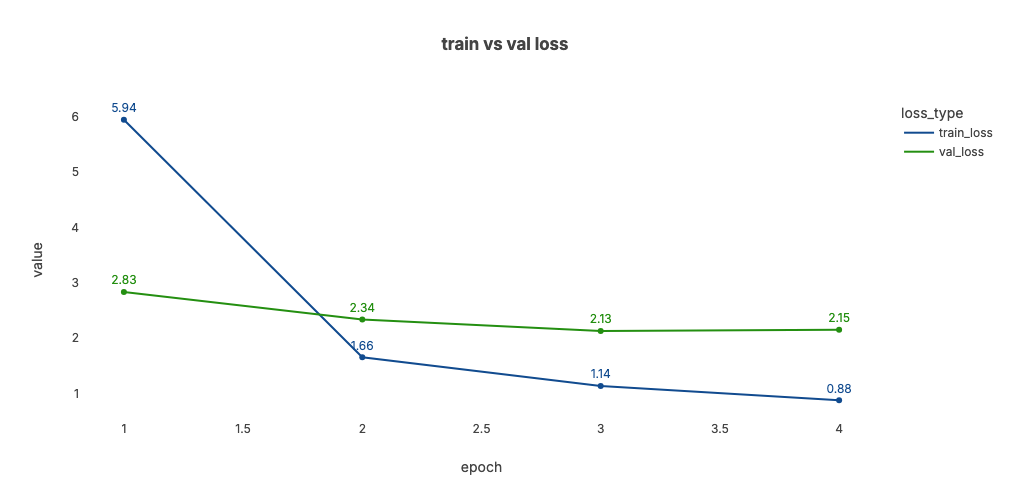

In [44]:
plot_train_vs_val_loss(epoch_metrics_df, height=500)

# Predict

In [21]:
train_df

,user_id,parent_asin,rating,timestamp
1,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B0863MT183,4.0,1613701986538
2,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B08P8P7686,5.0,1613702112995
3,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B0B7LV3DN2,4.0,1617641445475
4,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B09WMQ6DXG,5.0,1620231368468
70,AHV6QCNBJNSGLATP56JAWJ3C4G2A,B019WRM1IA,5.0,1451860309000
...,...,...,...,...
735704,AHS2PQ33BWQLXC5NNUZS2BFXD34Q,B07TZT67KX,5.0,1622844181866
735800,AFO5SNKILFVJMSJJ2E3BRLDGE4NA,B09T5VN7D1,4.0,1601154352542
735801,AFO5SNKILFVJMSJJ2E3BRLDGE4NA,B09918MSTF,5.0,1602615880364
736772,AEFPHMM7CLX4UJNXJFQF4ZF5GNAA,B07P27XFP7,5.0,1599585146628


In [22]:
user_id = 'AEHW2B54HDLZ3APBEWXHYLZ6SSYQ'
val_df.loc[lambda df: df['user_id'].eq(user_id)]

,user_id,parent_asin,rating,timestamp
34367,AEHW2B54HDLZ3APBEWXHYLZ6SSYQ,B07MYVF61Y,4.0,1654225907045


In [23]:
item_id = 'B07MYVF61Y'
user_indice = idm.get_user_index(user_id)
item_indice = idm.get_item_index(item_id)

model.predict([user_indice], [item_indice])

tensor(4.3279, device='cuda:0', grad_fn=<AddBackward0>)